In [1]:
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
import gensim
from numpy.linalg import norm
from numpy import array
from sklearn.decomposition import PCA
from numpy import histogramdd
from numpy.fft import rfftn, fftn, fftshift
from numpy import abs, log, vstack, exp
import matplotlib.pyplot as plt
from sklearn.neighbors.kde import KernelDensity
from numpy import arange, linspace, meshgrid, sum, rot90
from os.path import expanduser, join
from functools import partial

%matplotlib inline

In [2]:
def text_to_words(review, remove_stopwords=False, html=False):
    # html clean
    if html:
        review_text = BeautifulSoup(review).get_text()
    else:
        review_text = review
    
    # letters stay
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    
    words = review_text.lower().split()
    
    # stopwors
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    return(words)

model = gensim.models.Word2Vec.load_word2vec_format(expanduser('~/data/nlp/GoogleNews-vectors-negative300.bin'), 
                                                    binary=True)  

In [3]:
fnames = ['bible', 'ulysses', 'war_and_peace']
fpath = '~/data/nlp/books/'
ext = 'txt'
ffs = map(lambda x: join(expanduser(fpath), x + '.' + ext), fnames)

In [4]:
def get_vecs(fname):
    f = open(fname)
    raw = f.read()
    w_list = text_to_words(raw)
    uw_list = list(set(w_list))
    return uw_list

In [5]:
uwords = map(get_vecs, ffs)

In [6]:
def words2inds(words):
    intersection = list(set(words) & set(model.vocab.keys()))
    print len(intersection), len(words)
    return map(lambda w: model.vocab[w].index, intersection)

In [7]:
uinds = map(words2inds, uwords)
datasets = map(lambda x: model.syn0[array(x)], uinds)

7902 12568
21443 29006
15904 17454


In [8]:
n_comps = 2

def get_transormed_data(X):
    pca = PCA(n_components=n_comps)
    pca.fit(X)
    X_red = pca.transform(X)
    return X_red, pca.explained_variance_ratio_

In [9]:
datasets_ = map(get_transormed_data, datasets)

In [10]:
datasets_tr = map(lambda x: x[0], datasets_)
datasets_var = map(lambda x: x[1], datasets_)

In [11]:
from numpy.fft import rfftn

def plot_power_spectrum(X, box_dim):
    box_length = 2**box_dim
    bin_dims = tuple([box_length]*n_comps)
    rho, edges = histogramdd(X, bins=bin_dims)
    rho_tr = fftn(rho)
    plt.imshow(rho)
    plt.show()
    plt.imshow(log(abs(fftshift(rho_tr))**2))
    plt.show()
    
    from numpy.fft import rfftn

def plot_power_spectrum_real(X, box_dim):
    box_length = 2**box_dim
    bin_dims = tuple([box_length]*n_comps)
    rho, edges = histogramdd(X, bins=bin_dims)
    rho_tr = rfftn(rho)
    plt.imshow(rho)
    plt.show()
    plt.imshow(log(abs((rho_tr))**2))
    plt.show()

In [12]:
def plot_kde_and_fftit(X, box_dim):
    kde = KernelDensity(kernel='epanechnikov', bandwidth=0.2, algorithm='kd_tree').fit(X)

    xa, xb = min(X.T[0]), max(X.T[0])
    ya, yb = min(X.T[1]), max(X.T[1])
    box_length = 2**box_dim
    x = linspace(xa, xb, box_length)
    y = linspace(ya, yb, box_length)
    xx, yy = meshgrid(x, y)
    xy = vstack([xx.ravel(), yy.ravel()]).T
    rho = exp(kde.score_samples(xy)).reshape(xx.shape)
    # print 'check (sums to almost one)', sum(zz, axis=(0,1))*(xb-xa)*(yb-ya)/box_length**2
    bin_dims = tuple([box_length]*n_comps)
    rho_tr = fftn(rho)
    # plt.imshow(zz, cmap=plt.cm.gist_earth_r)
    plt.imshow(rot90(rho, k=-1))
    plt.show()
    plt.imshow(log(abs(fftshift(rho_tr))**2))
    plt.show()

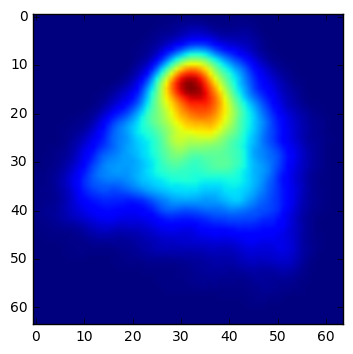

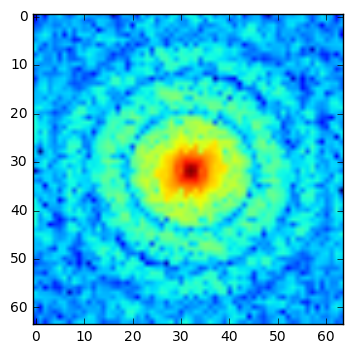

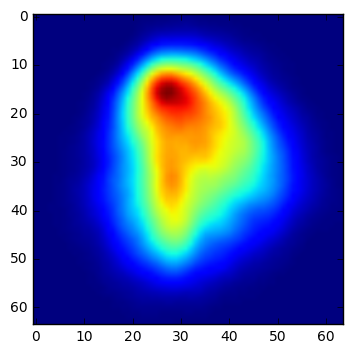

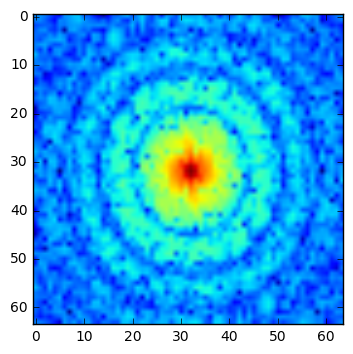

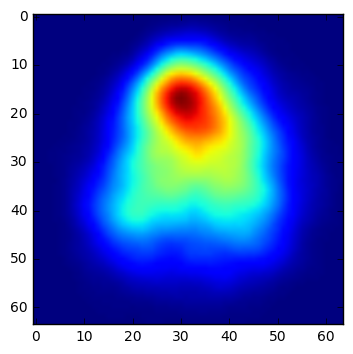

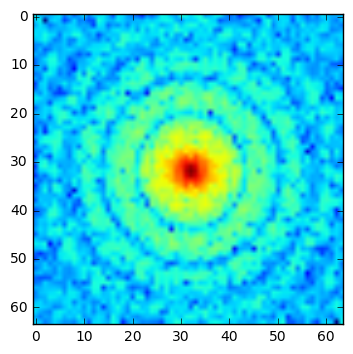

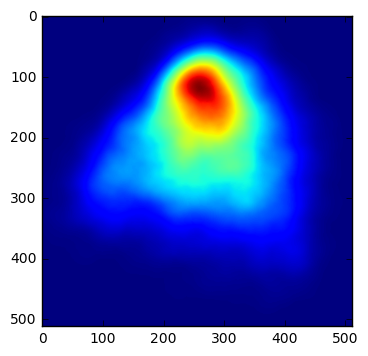

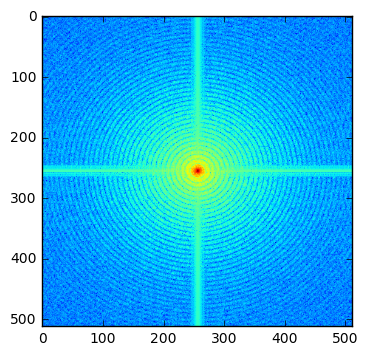

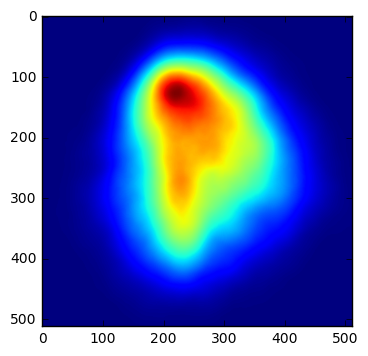

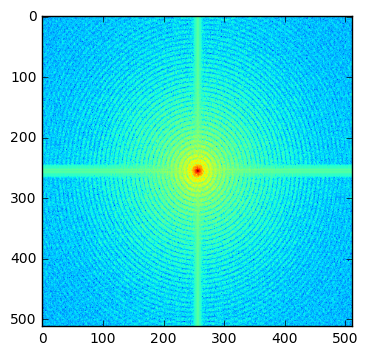

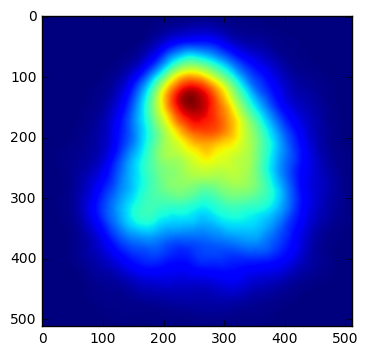

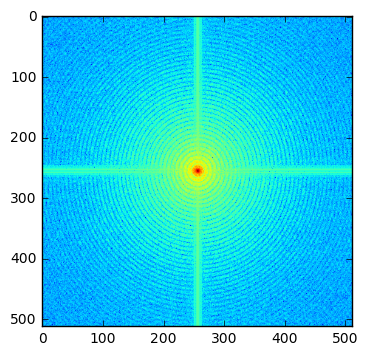

[None, None, None]

In [13]:
# various kde artifacts
foo = partial(plot_kde_and_fftit, **{'box_dim':6})
map(foo, datasets_tr)
foo = partial(plot_kde_and_fftit, **{'box_dim':9})
map(foo, datasets_tr)

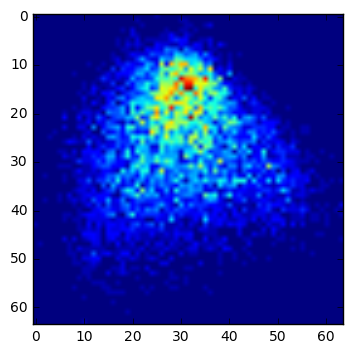

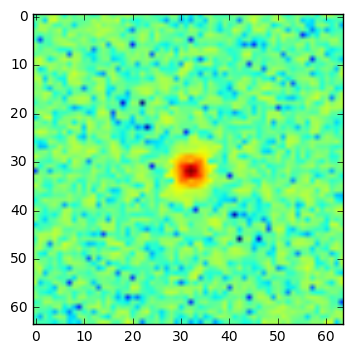

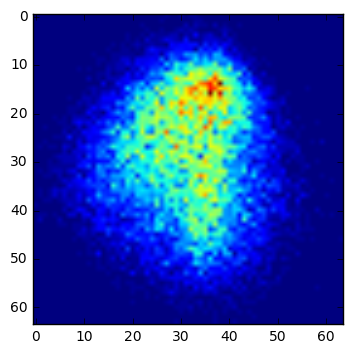

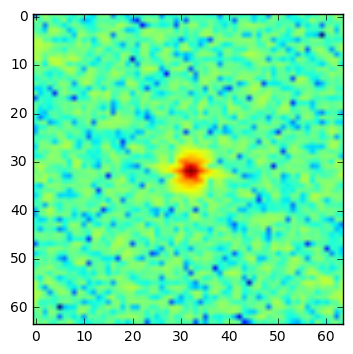

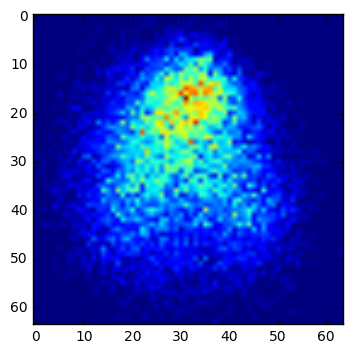

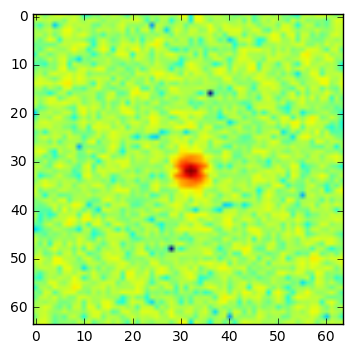

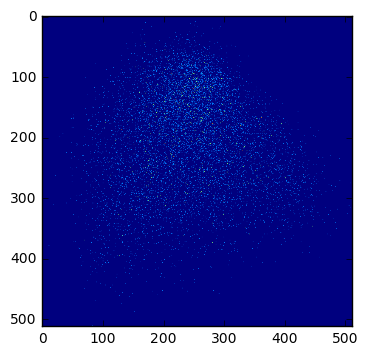

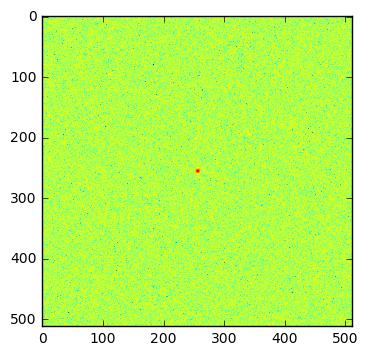

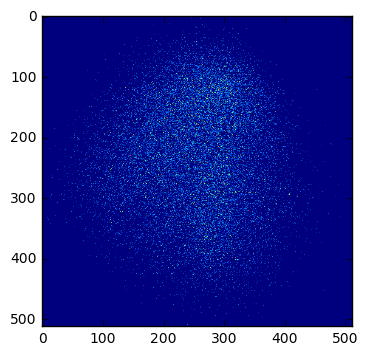

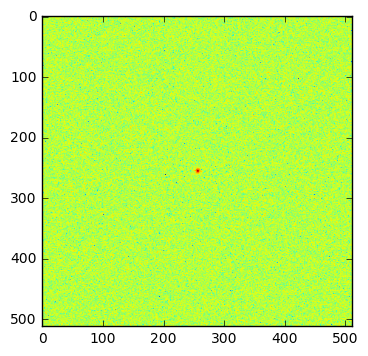

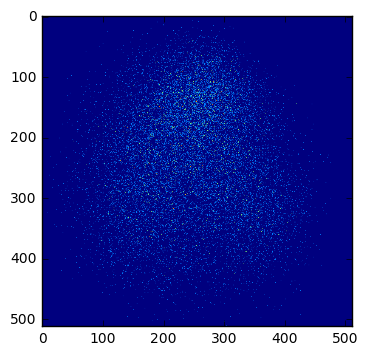

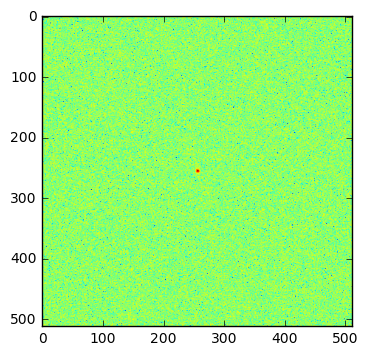

[None, None, None]

In [14]:
foo = partial(plot_power_spectrum, **{'box_dim':6})
map(foo, datasets_tr)
foo = partial(plot_power_spectrum, **{'box_dim':9})
map(foo, datasets_tr)